### Tests for the spline.
(with numerical derivatives)

splines agree:  True


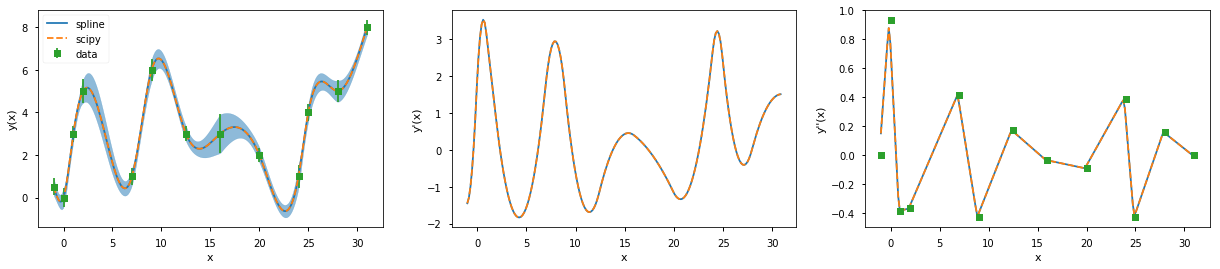

In [86]:
import numpy as np
import scipy.linalg as la
from scipy.interpolate import CubicSpline
from ca_uncert import CubicSplineUncertainty
import matplotlib.pyplot as plt
%matplotlib inline


# Input.
x = np.array([-1, 0, 1, 2, 7, 9, 12.5, 16, 20, 24, 25, 28, 31])
y = np.array([0.5, 0, 3, 5, 1, 6, 3, 3, 2, 1, 4, 5, 8])
sig = np.array([0.4, 0.45, .375, 0.55, 0.39, 0.51, 0.35, 0.91, 0.35, 0.55, 0.39, 0.51, 0.35])


# Spline.
csu = CubicSplineUncertainty(x, y, sig)
x_spline = np.linspace(np.min(x), np.max(x), 200)
y_spline, sig_spline = csu.interpolate(x_spline)

# Plot.
with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(21, 4)
    
    # spline.
    # -----------------------------------------------------------------------
    
    # cubic spline + uncertainty.
    line, = ax[0].plot(x_spline, y_spline, label='spline')
    ax[0].fill_between(x_spline, y_spline-sig_spline,  y_spline+sig_spline, alpha=0.5, color=line.get_color())
    
    # numpy solution.
    cs = CubicSpline(x, y, bc_type='natural')
    y_scipy = cs(x_spline)
    ax[0].plot(x_spline, y_scipy, linestyle='--', label='scipy')
    
    # Check if the results agree.
    print('splines agree: ', np.allclose(y_spline, y_scipy))
    
    # input data (for comparison).
    ax[0].errorbar(x, y, sig, marker='s', linestyle='', label='data')
    
    ax[0].set_ylabel("y(x)")
    ax[0].legend()
    
    
    # first derivatives.
    # -----------------------------------------------------------------------
    ax[1].plot(x_spline[:-1], np.diff(y_spline)/np.diff(x_spline))
    ax[1].plot(x_spline[:-1], np.diff(y_scipy)/np.diff(x_spline), linestyle='--')
    ax[1].set_ylabel("y'(x)")
        
    
    # second derivatives.
    # -----------------------------------------------------------------------
    ax[2].plot(x_spline[:-2], np.diff(np.diff(y_spline)/np.diff(x_spline)))
    ax[2].plot(x_spline[:-2], np.diff(np.diff(y_scipy)/np.diff(x_spline)), linestyle='--')
    ax[2].plot(csu.x, csu.s*((np.max(x)-np.min(x))/len(x_spline)), marker='s', linestyle='')
    ax[2].set_ylabel("y''(x)")
    
    
    # plot cosmetics.
    for a in ax:
        a.set_xlabel('x')

### Tests for the derivative.

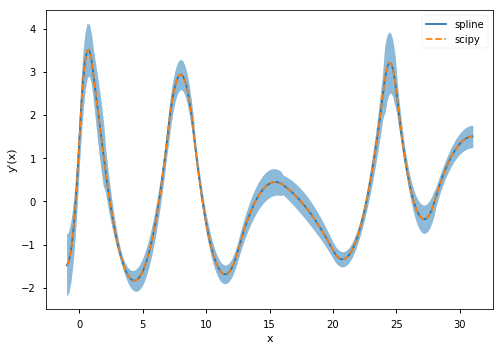

In [87]:
with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots()

    yp_spline, sigp_spline = csu.interpolate(x_spline, order=1)
    line, = ax.plot(x_spline, yp_spline, label='spline')
    ax.fill_between(x_spline, yp_spline-sigp_spline,  yp_spline+sigp_spline, alpha=0.5, color=line.get_color())
    
    # scipy comparison.
    yp_scipy = cs(x_spline, 1)
    ax.plot(x_spline, yp_scipy, label='scipy', linestyle='--')
    
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel("y'(x)")